In [83]:
import os
import pathlib
import geopandas as gpd

import pandas as pd
import rioxarray as rxr

# Import packages
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns


In [84]:
# Load stored objects

%store -r srtm_c_da maca_df comanche_gdf

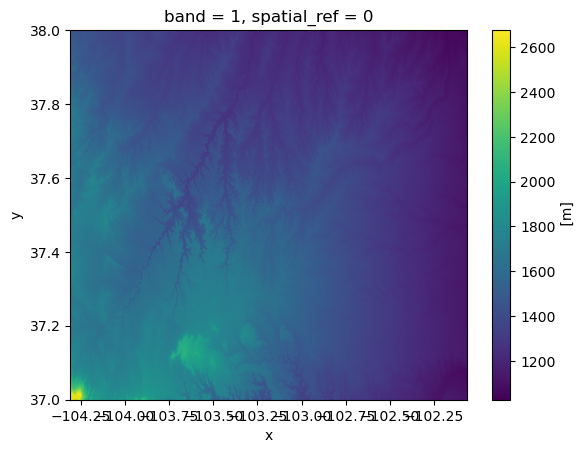

In [85]:
srtm_c_da.plot()

In [86]:
maca_df.drop('da', axis='columns')

,site_name,variable,start_year
0,comanche,pr,2096


(array([2.293443e+07, 2.565790e+05, 2.710100e+04, 5.818000e+03,
        1.643000e+03, 4.360000e+02, 1.210000e+02, 4.500000e+01,
        1.000000e+01, 9.000000e+00]),
 array([   0.        ,  297.32266235,  594.64532471,  891.96801758,
        1189.29064941, 1486.61328125, 1783.93603516, 2081.25854492,
        2378.58129883, 2675.90405273, 2973.2265625 ]),
 <BarContainer object of 10 artists>)

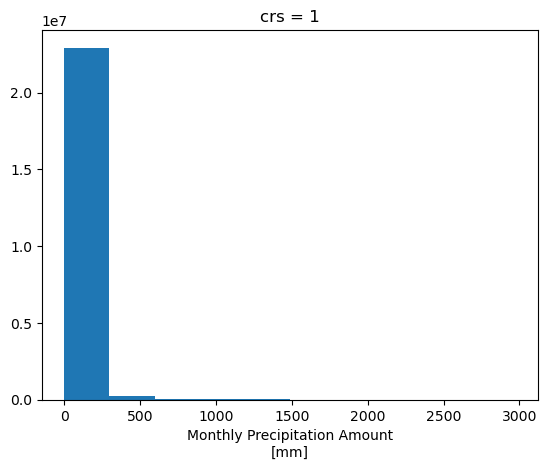

In [87]:
(maca_df[(maca_df.start_year==2096) 
         & (maca_df.variable=='pr')]
         .da.values.item()
).plot.hist()

Figure 8: This was a histogram plot of the maca precipitation data that was used to check if the maca data was sourced correctly. Note: it is NOT clipped to the study area, so this plot should not be used to analyze Comanche grassland precipitation values.

In [88]:
# define "maca_2096_original_da" (in this case, maca precipitation data projected forward to the year 2096)

maca_2096_original_da = (
    maca_df
    [(maca_df.start_year==2096) & (maca_df.variable=='pr')]
    .da.values.item()
    .groupby('time.year')
    .sum()
    .min('year')
    .rio.write_crs(4326)
    .rio.set_spatial_dims(y_dim='lat', x_dim='lon')
)

In [89]:
maca_2096_original_da

<xarray.DataArray 'precipitation' (lat: 585, lon: 1386)> Size: 3MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * lat          (lat) float64 5kB 25.06 25.1 25.15 25.19 ... 49.31 49.35 49.4
    crs          int32 4B 1
  * lon          (lon) float64 11kB -124.8 -124.7 -124.7 ... -67.11 -67.06
    spatial_ref  int64 8B 0

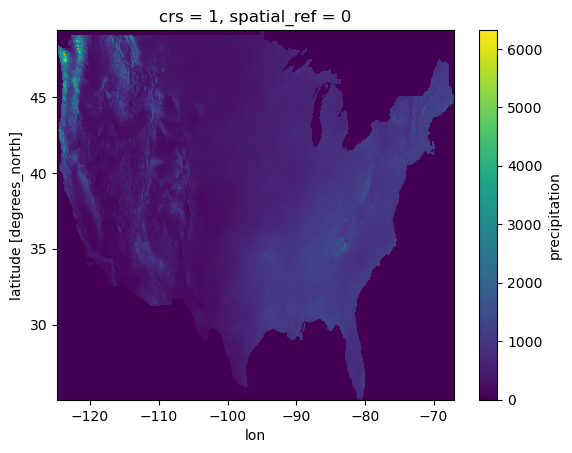

In [90]:
maca_2096_original_da.plot()

Figure 9: Another plot used to check the maca data download. Note: the shape of the entire United States is visible, indicating that the data is not clipped to the grassland's extent!

In [91]:
comanche_gdf.total_bounds

array([-104.05931301,   36.99460905, -102.31361457,   37.91380663])

In [92]:
# reproject the comanche_gdf to the same crs as maca_2096_original_da

comanche_gdf.to_crs(maca_2096_original_da.rio.crs)

,NATIONALGR,GRASSLANDN,GIS_ACRES,SHAPE_AREA,SHAPE_LEN,geometry
16,295522010328,Comanche National Grassland,444413.904,0.183064,26.658022,"MULTIPOLYGON (((-104.02263 37.69225, -104.0225..."


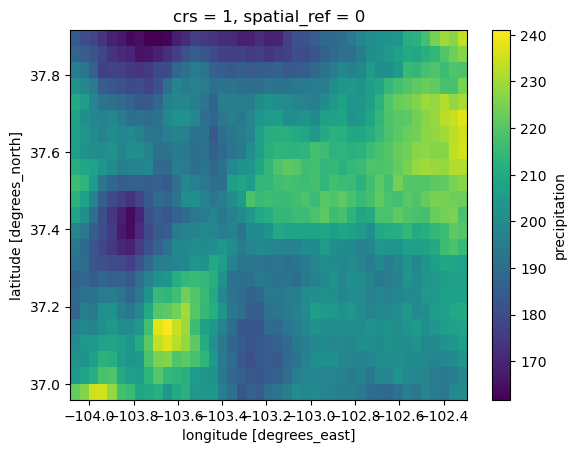

In [93]:
# Clip the maca raster to the bounds of the comanche gdf.

maca_2096_cropped = maca_2096_original_da.rio.clip_box(
    *comanche_gdf.to_crs(maca_2096_original_da.rio.crs).total_bounds
    )
maca_2096_cropped.plot()

Figure 10: This is the clipped maca precipitation data. The bounds of the plot have now been clipped to the extent of the Comanche National Grasslands boundaries. This is evident from the longitude and latitude values on the axis of the plot, which match the Comanche bounds.

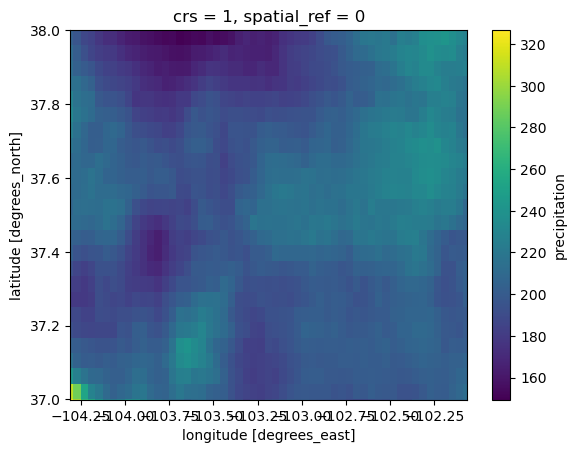

In [94]:
# Harmonize the maca data with the srtm data by reprojecting the maca raster into the same crs as srtm_c_da

maca_2096_da = maca_2096_original_da.rio.reproject_match(srtm_c_da)
maca_2096_da.plot()

Figure 11: the reprojected maca precipitation data has been harmonized to match the coordinate reference system of the srtm DEM (Digital Elevation Model).

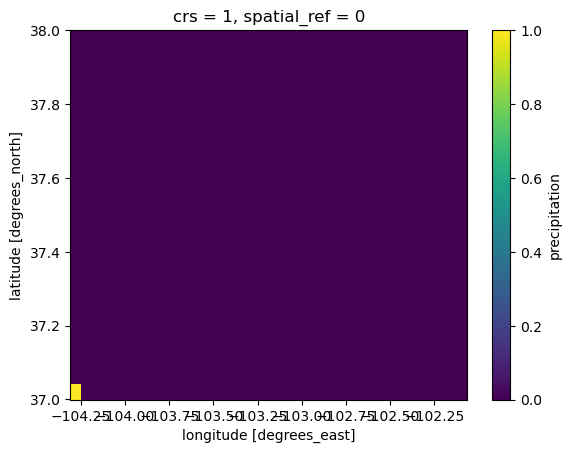

In [95]:
# Input precipitation tolerance value from research. 
# For subsequent runs with different species, update this to match the new tolerance value.

maca_suitable = maca_2096_da > 280
maca_suitable.plot()

Figure 12: This raster is derived from the maca precipitation data, projected forward to the year 2096. The raster gives a value of 1 (yellow) in areas that will be suitable for sorghastrum nutans in the year 2096 given the rcp85 scenario, which is a more extreme climate change scenario, and a 0 (purple) in areas that will be unsuitable. According to the model, only a small patch in the Southwest corner will be habitable by Sorghastrum nutans.

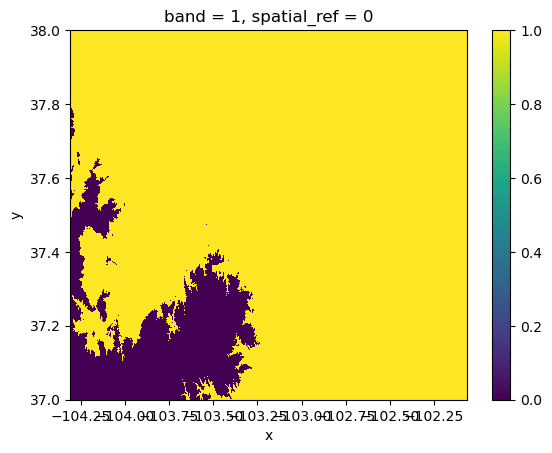

In [96]:
# Input elevation tolerance value from research
# For subsequent runs with different species, update this value to match the new species tolerance.

srtm_suitable_da = srtm_c_da < 1700
srtm_suitable_da.plot()

Figure 13: Elevation tolerance of Sorghastrum nutans. This raster contains a 1 (yellow) in areas that have suitable elevation for Sorghastrum nutans to grow, and a 0 (purple) for elevations that are not suitable. 

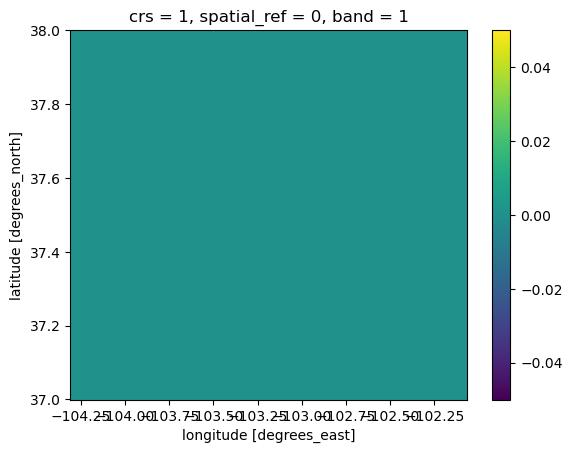

In [97]:
# find areas with suitable precip and elevation for Sorghastrum nutans, by multiplying the suitability rasters together to create a combined raster.

suitable_2096 = maca_suitable * srtm_suitable_da
suitable_2096.plot()

Figure 14: This is the combined suitability raster for Sorghastrum nutans, obtained by multiplying the precipitation suitability raster by the elevation suitability raster. The teal square means that in an rcp85 climate scenario, nowhere in the square between latitude 37 and 38, and longitude -102.25 and -104.25 is habitable by Sorghastrum nutans. 

Pseudocode to create suitability rasters from the POLARIS soil pH data:

* Reproject the soil suitability rasters into UTM 13 N
* Clip soil suitability rasters to the study area bounds
* Set the tolerance ranges. Suitable habitat for nutans is between pH 4.8 and 8.0. 
* pH_suitable = 8.0 > pH < 4.8
* This could then be combined with elevation or precipitation data by multiplication to create a composite suitability raster.